<font size="5" color="navy" face="Tahoma"><br><b>Создание прототипа модели машинного обучения для «Цифры»</b></font>
<hr>

<font size="3" face="Tahoma">
    <b>Основная цель сборного проекта:</b><br> создать прототип модели машинного обучения для компании, разрабатывающая решения для эффективной работы промышленных предприятий.<br>
    <br>
    <b>Требования к модели:</b><br>должна предсказывать коэффициенты восстановления золота из золотосодержащей руды, что позволит оптимизировать производство и не запускать предприятия с убыточными хараетеристиками.<br>
    <br>
     <b>Работа над проектом будет состоять из нескольких этапов:</b>
 <ol>
    <li>Подготовка данных;</li>
    <li>Исследовательский анализ данных;</li>
    <li>Построние и обучение модели.</li>
 </ol>
   </font>

<font size="5" color="navy" face="Tahoma"><b>Подготовка данных</b></font>

<font size="4" color="navy" face="Tahoma">
    1.1. Загрузим файлы и изучим их</font>

In [52]:
# загрузим необходимые библиотеки для проекта
import pandas as pd
import numpy as np
import warnings

import scipy.stats as st
from scipy.stats import mannwhitneyu

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score,GridSearchCV,KFold
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [53]:
# загрузим исходные данные с временной индексацией

gold_recovery_train=pd.read_csv('gold_recovery_train.csv',
                                index_col=['date'], parse_dates=['date'], dayfirst=True)
gold_recovery_test=pd.read_csv('gold_recovery_test.csv',
                               index_col=['date'], parse_dates=['date'], dayfirst=True)
gold_recovery_full=pd.read_csv('gold_recovery_full.csv',
                               index_col=['date'], parse_dates=['date'], dayfirst=True)

In [54]:
# отобразим несколько строк исходных данных
gold_recovery_full.head(3)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


In [55]:
# отобразим размер данных
print('Размер обучающей выборки:',*gold_recovery_train.shape)
print('Размер тестовой выборки: ',*gold_recovery_test.shape)
print('Размер исходных данных:  ',*gold_recovery_full.shape)

Размер обучающей выборки: 16860 86
Размер тестовой выборки:  5856 52
Размер исходных данных:   22716 86


In [56]:
# ознакомимся с сводной информацией о данных
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float64
primary_c

In [57]:
# рассчитаем долю пропущенных значений в данных
passes=round(gold_recovery_full.isna().sum()/len(gold_recovery_full)*100,1)

# посмотрим в каких признаках пропусков более 5%
display (passes[passes>5])

final.output.recovery                  8.6
primary_cleaner.input.sulfate          7.1
primary_cleaner.input.depressant       6.8
primary_cleaner.input.xanthate         5.1
rougher.calculation.au_pb_ratio        7.2
rougher.input.floatbank10_sulfate      5.7
rougher.input.floatbank11_xanthate     9.9
rougher.output.recovery               13.7
rougher.output.tail_ag                12.0
rougher.output.tail_sol               12.0
rougher.output.tail_au                12.0
secondary_cleaner.output.tail_sol      9.8
dtype: float64

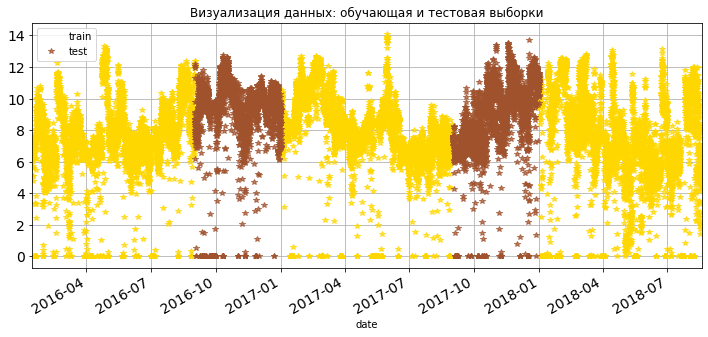

In [58]:
# визуализируем вместе обучающую и тестовую выбороки

title='Визуализация данных: обучающая и тестовая выборки'
ax=gold_recovery_train['rougher.input.feed_au'].plot(style='*',color='gold',alpha=0.75,grid=True,
                                                     figsize=(14,5),title=title,fontsize=14,label='train',legend=True)
gold_recovery_test['rougher.input.feed_au'].plot(style='*',color='sienna',alpha=0.75,grid=True,ax=ax,
                                                     figsize=(12,5),title=title,fontsize=14,label='test',legend=True)
plt.show()

<font size="3" face="Tahoma"><b>Выводы:</b><br>
Скрининг исходных данных по обогащению золотоносной руды дал следующие результаты:<br>
- исходные данные были разбиты на выборки по временному ряду: в обучающую выборку включили три временных ряда, а в тестовую - два;<br>
- в тестовой выборке отсутсвтуют 34 признака;<br>
- в данных много пропусков.
</font>

<font size="4" color="navy" face="Tahoma">
    1.2. Рассчитаем эффективность обогощения по формуле:<br>
    $$recovery={C*(F-T)\over F*(C-T)}, где:$$
C — доля золота в концентрате после флотации/очистки;<br>
F — доля золота в сырье/концентрате до флотации/очистки;<br>
T — доля золота в отвальных хвостах после флотации/очистки.<br>

Проверим правильность рассчетов. Вычислим эффективность на обучающей выборке для признака rougher.output.recovery. Найдем MAE между полученными расчётами и значением признака.</font>

In [59]:
# Расcчитаем эффективность
# исключим пропуски из данных 
step=gold_recovery_train[~gold_recovery_train['rougher.output.concentrate_au'].isna()].copy()
step=step[~step['rougher.input.feed_au'].isna()]
step=step[~step['rougher.output.tail_au'].isna()]
step=step[~step['rougher.output.recovery'].isna()]

C=step['rougher.output.concentrate_au']
F=step['rougher.input.feed_au']
T=step['rougher.output.tail_au']

data={'c':C,'f':F,'t':T}

recovery=pd.DataFrame(data=data)

recovery['rec']=(recovery['c']*(recovery['f']-recovery['t'])/
                 (recovery['f']*(recovery['c']-recovery['t']))*100)

recovery[~recovery['rec'].isna()].head()

,c,f,t,rec
date,,,,
2016-01-15 00:00:00,19.793808,6.486150,1.170244,87.107763
2016-01-15 01:00:00,20.050975,6.478583,1.184827,86.843261
2016-01-15 02:00:00,19.737170,6.362222,1.162562,86.842308
2016-01-15 03:00:00,19.320810,6.118189,1.079755,87.226430
2016-01-15 04:00:00,19.216101,5.663707,1.012642,86.688794


In [60]:
# проверим расcчет эффективности с помощью метрики MAE
mae=mean_absolute_error(step['rougher.output.recovery'],recovery['rec'])
print('mae:{:.15%}'.format(mae))
print('mediana target: {}'.format(step['rougher.output.recovery'].median()))
print('mediana calculated: {}'.format(step['rougher.output.recovery'].median()))

mae:0.000000000000944%
mediana target: 85.23599666059937
mediana calculated: 85.23599666059937


<font size="3" face="Tahoma"><b>Выводы:</b><br>
Значение метрики MAE показвает, что в среднем расcчетный recovery и целевой recovery отличаются на 0%, так как значение очень мало. Это значит, что константа MAE приближена по своему значению к медиане целевого признака. Следовательно, <b>расчет эффективности верен</b>.
</font>

<font size="4" color="navy" face="Tahoma">
    1.3. Проанализируем признаки, недоступные в тестовой выборке.</font>

In [61]:
# определим признаки в выборках train и test
columns_train=gold_recovery_train.columns
columns_test=gold_recovery_test.columns

# определим в каких признаках отличия 
results=list(set(columns_train)-set(columns_test))
steg=[]
parameter_type=[]
parameter_name=[]
for result in results:
    splits=result.split('.')
    steg.append(splits[0])
    parameter_type.append(splits[1])
    parameter_name.append(splits[2])
steg=list(set(steg))
parameter_type=list(set(parameter_type))
parameter_name=list(set(parameter_name))
print('Этапы:              ',steg)
print('Типы параметров:    ',parameter_type)
print('Названия параметров:',sorted(parameter_name))

Этапы:               ['final', 'secondary_cleaner', 'primary_cleaner', 'rougher']
Типы параметров:     ['calculation', 'output']
Названия параметров: ['au_pb_ratio', 'concentrate_ag', 'concentrate_au', 'concentrate_pb', 'concentrate_sol', 'floatbank10_sulfate_to_au_feed', 'floatbank11_sulfate_to_au_feed', 'recovery', 'sulfate_to_au_concentrate', 'tail_ag', 'tail_au', 'tail_pb', 'tail_sol']


<font size="3" face="Tahoma"><b>Выводы:</b><br>
- В тестовой выборке отсутствуют данные <b>финального этапа</b>: можно предположить, что именно это и <b>требуется в перспективе прогнозировать</b>.<br> 
- Также отсутствуют <b>расчетный характеристики</b> на всех этапах: можно предположить, что они не важны, так как всего лишь расчетные характеристики, которые <b>складываются из других признаков</b>.
- В текстовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса: можно предположить, что их невозможно получить/измерить во время выполнения технологического процесса.
</font>

<font size="4" color="navy" face="Tahoma">
    1.4. Проведем предобработку данных.</font>

In [62]:
# создадим название столбцов для признаков и цели
columns_garbage=['rougher.input.feed_au','rougher.output.concentrate_au','final.output.concentrate_au',
                 'rougher.input.feed_ag','rougher.output.concentrate_ag','final.output.concentrate_ag',
                 'rougher.input.feed_pb','rougher.output.concentrate_pb','final.output.concentrate_pb',
                 'rougher.input.feed_sol','rougher.output.concentrate_sol','final.output.concentrate_sol']
columns_features=gold_recovery_test.columns
columns_target=['rougher.output.recovery','final.output.recovery']

In [63]:
# создадим обучающую и тестовую выборки по индексации из исходных данных
train=gold_recovery_full.loc[gold_recovery_train.index]
test=gold_recovery_full.loc[gold_recovery_test.index]

In [64]:
# создадим целевые признаки для обучающей и тестовой выборок
target_train=train[columns_target]
target_test=test[columns_target]

# удалим пропуски из целевых признаков
target_train.dropna(inplace=True)
target_test.dropna(inplace=True)

C:\Users\NB 7\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\NB 7\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [65]:
# создадим признаки для обучающей и тестовой выборок по индексации целей
garbage=train[columns_garbage].loc[target_train.index].fillna(method='ffill')
features_train=train[columns_features].loc[target_train.index].fillna(method='ffill')
features_test=test[columns_features].loc[target_test.index].fillna(method='ffill')

In [66]:
# проверим размер полученных данных
garbage.shape,features_train.shape,features_test.shape

((14149, 12), (14149, 52), (5290, 52))

<font size="3" face="Tahoma"><b>Выводы:</b><br>
В процессе предобработки данных были сделаные следующие действия:<br>
- <b>удалили пропуски в целевых признаках</b>, так как данные значения должны быть истинными, это будет влиять на качество модели;
- <b>заполнили пропуски методом 'ffill'</b> , так как данные отсортированы по времени и по ним видно, что соседние объекты в выборке имеют практически одинаковые показатели.    
</font>

<font size="5" color="teal" face="Tahoma"><b>Анализ данных</b></font>

<font size="4" color="navy" face="Tahoma">
    2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.</font>

In [67]:
# сформируем данные для анализа концентрации мателлов (Au, Ag, Pb)
columns_au=['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
columns_ag=['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
columns_pb=['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

element_au=gold_recovery_full[columns_au]
element_ag=gold_recovery_full[columns_ag]
element_pb=gold_recovery_full[columns_pb]

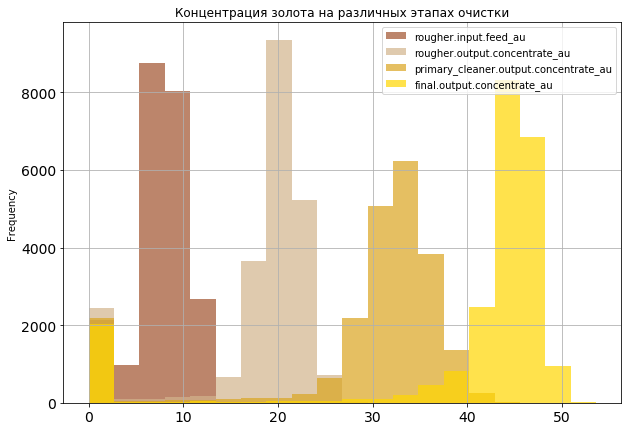

In [68]:
# визуализируем процесс очистки золотоносной руды
title='Концентрация золота на различных этапах очистки'
element_au.plot(kind='hist',grid=True,bins=20,color=['sienna','tan','goldenrod','gold'],
                alpha=0.70,figsize=(10,7),title=title,fontsize=14)
plt.show()

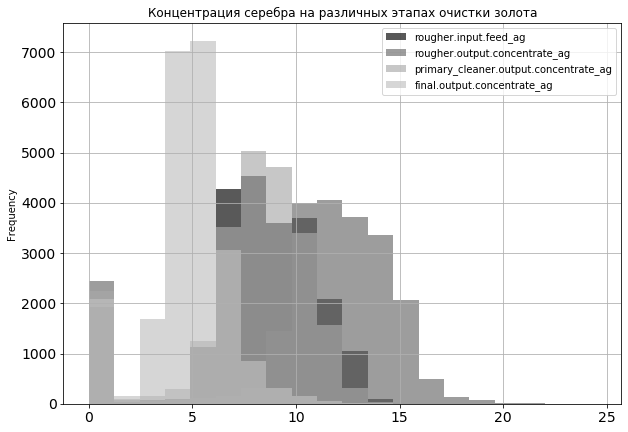

In [69]:
# визуализируем процесс изменения концентрации серебра в руде
title='Концентрация серебра на различных этапах очистки золота'
element_ag.plot(kind='hist',grid=True,bins=20,color=['k','dimgray','darkgray','silver'],
                alpha=0.65,figsize=(10,7),title=title,fontsize=14)
plt.show()

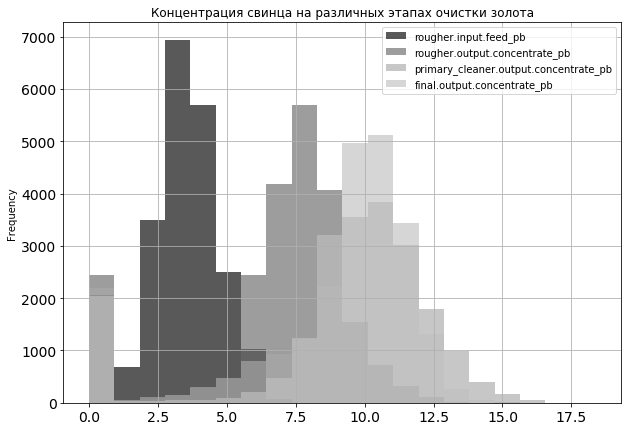

In [70]:
# визуализируем процесс изменения концентрации свинца в руде 
title='Концентрация свинца на различных этапах очистки золота'
element_pb.plot(kind='hist',grid=True,bins=20,color=['k','dimgray','darkgray','silver'],
                alpha=0.65,figsize=(10,7),title=title,fontsize=14)
plt.show()

In [71]:
# рассчитаем количественные показатели изменения концентрации золота
element_au.mean(axis=0)

rougher.input.feed_au                     7.565838
rougher.output.concentrate_au            17.879538
primary_cleaner.output.concentrate_au    29.212289
final.output.concentrate_au              40.001172
dtype: float64

In [72]:
# рассчитаем количественные показатели изменения концентрации серебра
element_ag.mean(axis=0)

rougher.input.feed_ag                     8.065715
rougher.output.concentrate_ag            10.874484
primary_cleaner.output.concentrate_ag     7.691652
final.output.concentrate_ag               4.781559
dtype: float64

In [73]:
# рассчитаем количественные показатели изменения концентрации свинца
element_pb.mean(axis=0)

rougher.input.feed_pb                    3.305676
rougher.output.concentrate_pb            6.900646
primary_cleaner.output.concentrate_pb    8.921110
final.output.concentrate_pb              9.095308
dtype: float64

<font size="3" face="Tahoma"><b>Выводы:</b><br>
В процессе анализа концентрации металлов (золота, серебра, свинца) на различных этапах отчистки получили следующие результаты:<br>
- на каждом последующем этапе очистки четко отслеживается <b>увеличения концентрации золота</b> от 7.6 до 40.0 в среднем, то есть мы добиваемся максимального "извлечения" из золотоносной руды золота;
- на первых двух этапах <b>увеличивается концентрация серебра</b> от 8.0 до 10.9, на последующих этапах процесса  <b>концентрация серебра уменьшается </b> до 4.8;
- на каждом последующем этапе можно отследить <b> увеличение концентрации свинца</b> от 3.3 до 9.1 в среднем.
</font>

<font size="4" color="navy" face="Tahoma">2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.</font>

In [74]:
# создадим данные для анализа гранул сырья на обучающей и тестовой выборках
primary_test=features_test['primary_cleaner.input.feed_size']
primary_train=features_train['primary_cleaner.input.feed_size']
rougher_test=features_test['rougher.input.feed_size']
rougher_train=features_train['rougher.input.feed_size']

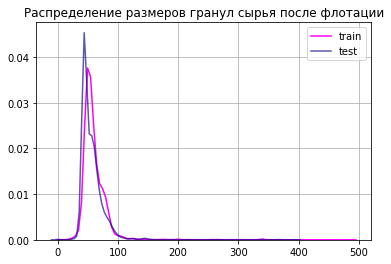

In [75]:
# визуализируем распределение размеров гранул сырья на обучающей и тестовой выборках после флотации 
sns.kdeplot(data=rougher_train,label='train',color='magenta')
sns.kdeplot(data=rougher_test,label='test',color='navy',alpha=0.65)
plt.grid(True)
plt.title('Распределение размеров гранул сырья после флотации')
plt.show()

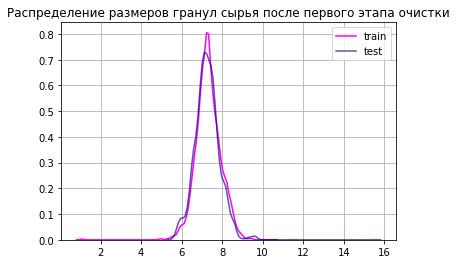

In [76]:
# визуализируем распределение размеров гранул сырья на обучающей и тестовой выборках после первого этапа очистки
sns.kdeplot(data=primary_train,label='train',color='magenta')
sns.kdeplot(data=primary_test,label='test',color='navy',alpha=0.65)
plt.grid(True)
plt.title('Распределение размеров гранул сырья после первого этапа очистки')
plt.show()

In [77]:
# создадим функцию для проверки различий гранул сырья
def difference (sample_train,sample_test,name_step):
    AB_difference = sample_train.mean() - sample_test.mean() 
    print("Разность средних значений размеров гранул после {} {:.4F}".format(name,AB_difference))
    
    bootstrap_samples = 1000
    state = np.random.RandomState(12345)
    count = 0
    
    for i in range(bootstrap_samples):
        subsample_A = sample_train.sample(frac=1, replace=True, random_state=state)
        subsample_B = sample_test.sample(frac=1, replace=True, random_state=state)
        bootstrap_difference = subsample_A.mean()-subsample_B.mean()
        if bootstrap_difference >= AB_difference:
            count += 1
    pvalue = count / bootstrap_samples
    print('p-value =', pvalue)
 
    if pvalue < 0.05:
        print("Отвергаем нулевую гипотезу: скорее всего, разница значительна.")
    else:
        print("Не получилось отвергнуть нулевую гипотезу: возможно, разница не велика.")

In [78]:
#  проверим различия гранул сырья после флотации
name='флотации'
difference(rougher_train,rougher_test,name)

Разность средних значений размеров гранул после флотации 4.2871
p-value = 0.478
Не получилось отвергнуть нулевую гипотезу: возможно, разница не велика.


In [79]:
#  проверим различия гранул сырья после первого этапа очистки
name='первого этапа отчистки'
difference(primary_train,primary_test,name)

Разность средних значений размеров гранул после первого этапа отчистки 0.0560
p-value = 0.493
Не получилось отвергнуть нулевую гипотезу: возможно, разница не велика.


In [80]:
# проверим различия распределения гранул сырья с помощью критерия Манна-Уитни
subsample_A = rougher_train.sample(frac=1, replace=True, random_state=123)
subsample_B = rougher_test.sample(frac=1, replace=True, random_state=123)
stat,pvalue=mannwhitneyu(subsample_A,subsample_B)
print('p-value =',pvalue)
alpha=0.05
if pvalue < 0.05:
    print("Отвергаем нулевую гипотезу: скорее всего, разница значительна.")
else:
    print("Не получилось отвергнуть нулевую гипотезу: возможно, разница не велика.")

p-value = 8.92195314289079e-105
Отвергаем нулевую гипотезу: скорее всего, разница значительна.


<font size="3" face="Tahoma"><b>Выводы:</b><br>
В процессе анализа различий гранул сырья после флотации и первого этапа отчистки получили следующие результаты:<br>
- <b>различия не существенны</b>, такой вывод можно сделать после визуализации данных;
- по разбросу данных видим, что примерно одинаковые значения, а сами выборки больше похожи на ненормальные (видим небольшую бимодальность);
- <b>различия существенны</b>, такой вывод можно сделать после проверки гипотезы с помощью непараметрического критерия Maнна-Уитни.
</font>

<font size="4" color="navy" face="Tahoma">2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.</font>

In [81]:
# создадим данные для исследования суммарной концентрации всех веществ
data=gold_recovery_full
substance_au=data['rougher.input.feed_au']+data['rougher.output.concentrate_au']+data['final.output.concentrate_au']
substance_ag=data['rougher.input.feed_ag']+data['rougher.output.concentrate_ag']+data['final.output.concentrate_ag']
substance_pb=data['rougher.input.feed_pb']+data['rougher.output.concentrate_pb']+data['final.output.concentrate_pb']
substance_sol=data['rougher.input.feed_sol']+data['rougher.output.concentrate_sol']+data['final.output.concentrate_sol']

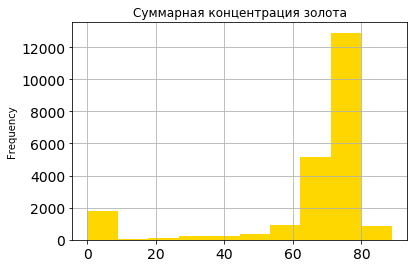

In [82]:
# визуализируем суммарную концентрацию золота
substance_au.plot(kind='hist',color='gold',grid=True,title='Суммарная концентрация золота',fontsize=14)
plt.show()

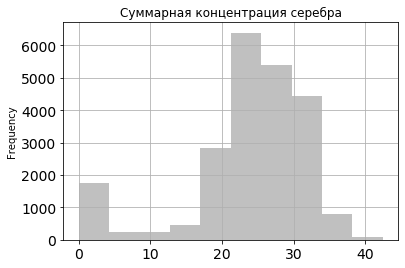

In [83]:
# визуализируем суммарную концентрацию серебра
substance_ag.plot(kind='hist',color='silver',grid=True,title='Суммарная концентрация серебра',fontsize=14)
plt.show()

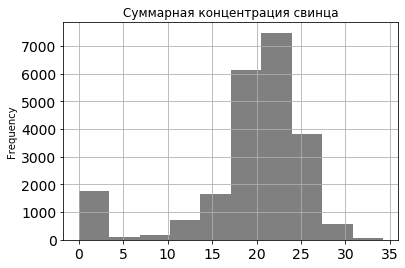

In [84]:
# визуализируем суммарную концентрацию свинца
substance_pb.plot(kind='hist',color='grey',grid=True,title='Суммарная концентрация свинца',fontsize=14)
plt.show()

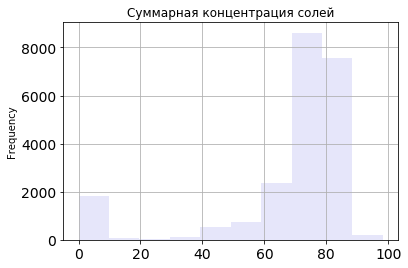

In [85]:
# визуализируем суммарную концентрацию солей
substance_sol.plot(kind='hist',color='lavender',grid=True,title='Суммарная концентрация солей',fontsize=14)
plt.show()

<font size="3" face="Tahoma"><b>Выводы:</b><br>
В процессе анализа суммарной концентрации веществ (золото, серебра, свинца и солей) на разных стадиях получили следующие результаты:<br>
- <b>данные нормально распределены</b> с небольшим смещением центра;
- <b>присутствуют аномальные значения (нулевые)</b>, которые будут искажать обучение моделей. Нулевые значения могут связаны со сбоем измерительного оборудования. Такие данные нужно удалять;
- для того чтобы данные не превратить в искусственные, выбросы оставим - это и есть реальная концентрация; нам важно, чтобы модель умела и их тоже видеть и обрабатывать.
</font>

In [86]:
# проверяем данные в обучающей и тестовой выборках на наличие "мусорных" данных и удаляем их
garbage_au=(garbage[['rougher.input.feed_au','rougher.output.concentrate_au','final.output.concentrate_au']].sum(axis=1)==0).sum()
garbage_ag=(garbage[['rougher.input.feed_ag','rougher.output.concentrate_ag','final.output.concentrate_ag']].sum(axis=1)==0).sum()
garbage_pb=(garbage[['rougher.input.feed_pb','rougher.output.concentrate_pb','final.output.concentrate_pb']].sum(axis=1)==0).sum()
garbage_sol=(garbage[['rougher.input.feed_sol','rougher.output.concentrate_sol','final.output.concentrate_sol']].sum(axis=1)==0).sum()
print('Проверка на наличия мусора в обучающей выборке:')
print('не обнаружен' if (garbage_au+garbage_ag+garbage_pb+garbage_sol)==0 else 'обнаружен')

Проверка на наличия мусора в обучающей выборке:
не обнаружен


<font size="3" face="Tahoma"><b>Данные готовы!</b></font>

<font size="5" color="navy" face="Tahoma"><b>Модель</b></font>

<font size="4" color="navy" face="Tahoma">3.1. Напишите функцию для вычисления итоговой sMAPE.</font>

In [87]:
# создадим функцию для вычисления итоговой sMAPE
def smape (target, prediction):
    summa=100*np.abs(target-prediction)/(np.abs(target)+np.abs(prediction)/2)
    return summa.mean()

<font size="4" color="navy" face="Tahoma">3.2. Обучим разные модели и оценим их качество кросс-валидацией. Выберим лучшую модель и проверим её на тестовой выборке.</font>

In [88]:
#создадим функцию для определния качества обученности модели
def quality(model):
    model_rougher= model.fit(features,target_rougher)
    predict_rougher=model_rougher.predict(features)
    smape_rougher=smape (target_rougher, predict_rougher)

    model_rougher= model.fit(features,target_final)
    predict_final=model_rougher.predict(features)
    smape_final=smape (target_final, predict_final)
    
    return smape_rougher, smape_final

In [89]:
# подготовим данные для обучения
target_rougher= target_train['rougher.output.recovery']
target_final= target_train['final.output.recovery']
features= features_train

In [91]:
# стандартизируем данные
scaler= StandardScaler().fit(features)
features = scaler.transform(features)

# создаем объект Линейной регрессии
linear= LinearRegression()

cross_rougher= cross_val_score(linear,features,target_rougher).mean()
cross_final= cross_val_score(linear,features,target_final).mean() 

# оценим качество модели
smape_rougher,smape_final=quality(linear)

#print('Средняя accuracy для флотации:{:.6f} '.format(cross_rougher))
#print('Средняя accuracy финиша:      {:.6f} '.format(cross_final))

print('sMAPE rougher: {:.4f}'.format(smape_rougher))
print('sMAPE final:   {:.4f}'.format(smape_final))

C:\Users\NB 7\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\NB 7\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


sMAPE rougher: 8.1365
sMAPE final:   6.3913


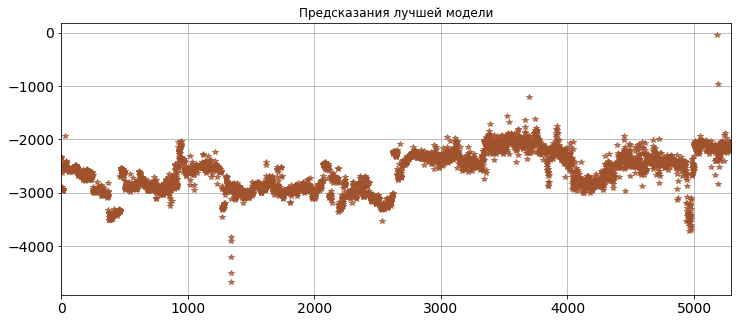

In [92]:
# проверим на тестовой выборке лучшую модель
predict=linear.predict(features_test)
title_test='Предсказания лучшей модели'
pd.Series(predict).plot(style='*',color='sienna',alpha=0.75,grid=True,figsize=(12,5),title=title_test,fontsize=14,label='test')
plt.show()

In [50]:
# обучим модель Случайный лес
result=[]
for estim in range (100,300,100):
    for depth in range(1,10):
        #estim=100
        forest=RandomForestRegressor(random_state=12345,n_estimators=estim,max_depth=depth,n_jobs=-1)
        score_rougher= cross_val_score(forest,features,target_rougher).mean()
        score_final = cross_val_score(forest,features,target_final).mean()
        smape_rougher,smape_final=quality(forest)
        #print('step ',depth)
        #print(estim,depth,score_rougher,score_final,smape_rougher,smape_final) 
        result.append([estim,depth,score_rougher,score_final,smape_rougher,smape_final])

C:\Users\NB 7\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\NB 7\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\NB 7\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\NB 7\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warn

C:\Users\NB 7\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\NB 7\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\NB 7\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\NB 7\Anaconda2\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warn

In [51]:
# оценим качество модели
quality_metrics=pd.DataFrame(data=result,columns=['estim','depth','rougher_score','final_score','smape_rougher','smape_final'])
quality_metrics

,estim,depth,rougher_score,final_score,smape_rougher,smape_final
0,100,1,-0.213869,-0.062905,9.241408,7.087314
1,100,2,-0.184905,0.014052,8.814101,6.814905
2,100,3,-0.164517,-0.046144,8.293330,6.443525
3,100,4,-0.169803,-0.069919,8.207838,6.193915
4,100,5,-0.102685,-0.061109,7.960079,5.961100
5,100,6,-0.103598,-0.044018,7.645370,5.722397
6,100,7,-0.119532,-0.058216,7.376065,5.464266
7,100,8,-0.141640,-0.073971,7.155344,5.210089
8,100,9,-0.179881,-0.091791,6.863506,4.968540
9,200,1,-0.214647,-0.064258,9.270733,7.080743


In [93]:
# создадим объект случайного леса
forest=RandomForestRegressor()

# создадим контейнер
pipe=Pipeline([('regressor',RandomForestRegressor())])
# создадим словарь гиперпараметров
search_space=([{'regressor':[RandomForestRegressor()],
               'regressor__n_estimators':[10,100,1000],
               'regressor__max_depth':[1,2,3,4,5,6,7,8,9,10]}])
# создадим объект решеточного поиска
gridsearch=GridSearchCV(pipe,search_space,cv=5,verbose=0,n_jobs=-1)

# выполним подгонку объекта решеточного поиска
best_model=gridsearch.fit(features,target_rougher)
smape_rougher,smape_final=quality(best_model)

In [94]:
# посмитрим на параметры лучшей модели
best_params=best_model.best_estimator_.get_params()['regressor']
print(best_params)
print('sMAPE rougher: {:.4f}'.format(smape_rougher))
print('sMAPE final:   {:.4f}'.format(smape_final))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
sMAPE rougher: 7.6132
sMAPE final:   5.9496


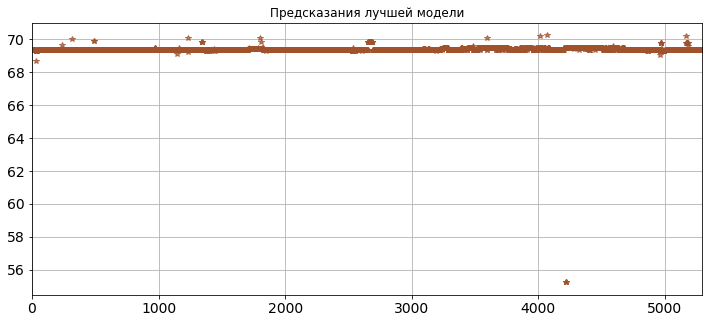

In [95]:
# проверим на тестовой выборке лучшую модель
predict=best_model.predict(features_test)
title_test='Предсказания лучшей модели'
pd.Series(predict).plot(style='*',color='sienna',alpha=0.75,grid=True,figsize=(12,5),title=title_test,fontsize=14,label='test')
plt.show()